In [ ]:
!git clone --depth=1 https://github.com/henrysky/astroNN
!pip install ./astroNN
!pip install --upgrade tensorflow-probability

Cloning into 'astroNN'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 221 (delta 8), reused 159 (delta 5), pack-reused 0
Receiving objects: 100% (221/221), 53.52 MiB | 15.41 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Processing ./astroNN
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 60.8 MB/s eta 0:00:00
  Created wheel for astroNN: filename=astroNN-1.2.dev0-py3-none-any.whl size=9336482 sha256=aa18fcaa3581b82b4d146c3016ebecec47a0cddc0bc4c61d816c9cbe74b163ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-2huko384/wheels/5a/67/c7/25e6092601f5d8f92abae18cb07ad36c8e7bcd89b30535f0a4
Successfully built astroNN
  Attempting uninstall: tensorflow_probability
    Found 

In [ ]:
from astroNN.datasets import load_galaxy10
from tensorflow import keras
from keras import utils
import numpy as np

# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = load_galaxy10()

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [02:43<00:00, 17.1MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [02:51, 15.9MB/s]                            


In [ ]:

from sklearn.model_selection import train_test_split

# split data into training set and the other set
train_idx, other_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.2)  # training set takes 80%
# split the other set into validation and testing sets
valid_idx, test_idx = train_test_split(other_idx, test_size=0.5)  # validation and testing set both take 10%

# get data by indexing
train_images, train_labels = images[train_idx], labels[train_idx]
valid_images, valid_labels = images[valid_idx], labels[valid_idx]
test_images, test_labels = images[test_idx], labels[test_idx]

In [ ]:
# delete images and labels to release RAM
del images, labels

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
# first conv layer
model.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# second conv layer
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# third conv layer
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten layer
model.add(Flatten())
# Dropout layer to avoid overfitting
model.add(Dropout(0.5))
# dense layer, where output is 10 types
model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.01)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0

In [ ]:
from keras.optimizers import Adam
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
optimizer = Adam(learning_rate=0.005)

# learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# train the model
history = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=50, batch_size=32, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
444/444 [==============================] - 20s 19ms/step - loss: 3.9287 - accuracy: 0.2970 - val_loss: 2.2454 - val_accuracy: 0.3501 - lr: 0.0010
Epoch 2/50
444/444 [==============================] - 6s 14ms/step - loss: 2.2699 - accuracy: 0.3547 - val_loss: 2.1095 - val_accuracy: 0.3946 - lr: 0.0010
Epoch 3/50
444/444 [==============================] - 6s 14ms/step - loss: 2.0614 - accuracy: 0.4086 - val_loss: 1.9282 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 4/50
444/444 [==============================] - 6s 14ms/step - loss: 1.9663 - accuracy: 0.4380 - val_loss: 2.1373 - val_accuracy: 0.3658 - lr: 0.0010
Epoch 5/50
444/444 [==============================] - 6s 14ms/step - loss: 1.9095 - accuracy: 0.4602 - val_loss: 1.8912 - val_accuracy: 0.4611 - lr: 0.0010
Epoch 6/50
444/444 [==============================] - 6s 14ms/step - loss: 1.8136 - accuracy: 0.4906 - val_loss: 1.8299 - val_accuracy: 0.4763 - lr: 0.0010
Epoch 7/50
444/444 [==============================] - 6s 14ms/s

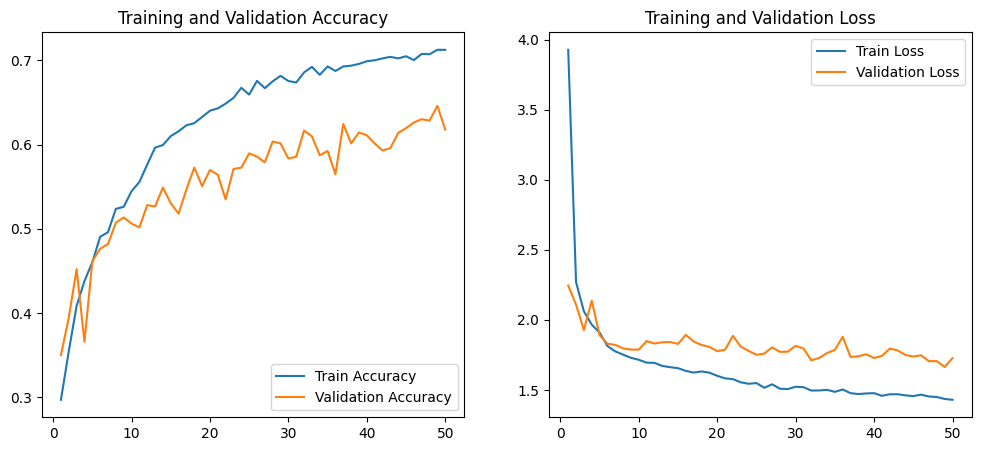

In [ ]:
import matplotlib.pyplot as plt

# get accuracies
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

# get losses
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

# create epoch's range
epochs_range = range(1, len(train_acc) + 1)

# plot epoch vs accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, valid_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot epoch vs loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, valid_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# delete unused data to release RAM
del train_images, train_labels, valid_images, valid_labels

In [ ]:
# predict the data
from sklearn import metrics
predictions = model.predict(test_images)

56/56 [==============================] - 1s 9ms/step


In [ ]:
# show the predictions
predictions

array([[5.18990383e-02, 1.21056335e-02, 3.76936048e-01, ...,
        6.59402832e-02, 5.39346875e-05, 1.69903797e-03],
       [5.05362563e-02, 2.17773784e-02, 5.50559402e-01, ...,
        1.07903123e-01, 1.71929714e-05, 1.10443728e-03],
       [3.35085802e-02, 4.13567126e-02, 1.47938761e-06, ...,
        2.39570322e-03, 9.01063740e-01, 4.51064343e-03],
       ...,
       [3.19984257e-01, 3.82388458e-02, 1.48097306e-05, ...,
        8.74831900e-02, 1.26670422e-02, 1.26461469e-04],
       [1.75730027e-02, 1.54576264e-02, 4.27180082e-02, ...,
        1.65788494e-02, 2.23419502e-05, 2.43673167e-05],
       [1.99794203e-01, 8.06452632e-02, 2.31020823e-02, ...,
        1.99705347e-01, 1.07549960e-02, 2.22274172e-03]], dtype=float32)

In [ ]:
# show the test label
test_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# turn predictions and test label into types
test_labels_class = np.argmax(test_labels, axis=1)
predictions_class = np.argmax(predictions, axis=1)

# calculate test accuracy
accuracy = accuracy_score(test_labels_class, predictions_class)

# calculate precision, recall, f1 score
precision = precision_score(test_labels_class, predictions_class, average='macro')
recall = recall_score(test_labels_class, predictions_class, average='macro')
f1 = f1_score(test_labels_class, predictions_class, average='macro')

# calculate ROC, AUC
lb = LabelBinarizer()
lb.fit(test_labels_class)
test_labels_bin = lb.transform(test_labels_class)
predictions_bin = lb.transform(predictions_class)
roc_auc = roc_auc_score(test_labels_bin, predictions_bin, average='macro')

# calculate confusion matrix
conf_mat = confusion_matrix(test_labels_class, predictions_class)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_mat}')

Accuracy: 0.6341600901916573
Precision: 0.6125114532759236
Recall: 0.6079551048586731
F1 Score: 0.5992887523355357
ROC AUC Score: 0.7833510964792412
Confusion Matrix:
[[ 28   7   8  16   1   6   7  20   5   3]
 [  5  83  23  18   3  19   7  12   8   3]
 [  3   6 224  11   0   4   8   9   0   0]
 [  5   2  20 175   0   1   2   5   0   1]
 [  5   0   0   8  14   0   0   0   3   1]
 [ 11   9   7   7   4 150  18  20   3   1]
 [  2   2   8   1   0  31 114  26   4   0]
 [ 18  16   8  11   0  38  55 108   3   1]
 [  2   1   0   0   0   0   0   0 128   1]
 [  2   9   0   7   5   2   1   2  48 101]]
